# Cosine KAN Transparency 

n_basis=8, grid=6, widths=(16,16)


In [81]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch

repo_root = Path.cwd().parent
sys.path.append(str(repo_root))

from synt_data.generate_cos_data import generate_cos_dataset
from timeview.basis import BSplineBasis
from mckan_pykan.config import MCKANPyKANConfig
from mckan_pykan.data import MCKANDataset
from mckan_pykan.data import create_train_val_test_dataloaders as create_kan_loaders
from mckan_pykan.training import training as kan_training


In [82]:
def prepare_static_history_from_df(df, history_end=1.0):
    static_cols = [c for c in df.columns if c not in ('trajectory_id', 't', 'y')]
    trajectory_ids = sorted(df['trajectory_id'].unique())

    X_static = (
        df.drop_duplicates('trajectory_id')
        .sort_values('trajectory_id')[static_cols]
        .to_numpy()
    )

    Zs, ts, ys_list = [], [], []
    for tid in trajectory_ids:
        traj = df[df['trajectory_id'] == tid].sort_values('t')
        t_vals = traj['t'].to_numpy()
        y_vals = traj['y'].to_numpy()

        hist_mask = t_vals <= history_end
        pred_mask = t_vals > history_end

        Zs.append(y_vals[hist_mask].reshape(-1, 1))
        ts.append(t_vals[pred_mask].copy())
        ys_list.append(y_vals[pred_mask].copy())

    return X_static, Zs, ts, ys_list


In [83]:
seed = 42
history_end = 1.0
T = 2.0
n_samples = 200
n_points = 40

kan_widths = [16, 16]
kan_grid = 6
kan_n_basis = 8
kan_epochs = 150
dataset_split = {'train': 0.8, 'val': 0.1, 'test': 0.1}

df = generate_cos_dataset(n_samples=n_samples, n_points=n_points, seed=seed, T=T)
X_static, Zs, ts, ys_list = prepare_static_history_from_df(df, history_end=history_end)


In [4]:
# Train MC-KAN
history_len = Zs[0].shape[0]
dynamic_feature_dim = Zs[0].shape[1]
n_dynamic_features = history_len * dynamic_feature_dim

kan_cfg = MCKANPyKANConfig(
    n_static_features=X_static.shape[1],
    n_dynamic_features=n_dynamic_features,
    n_basis=kan_n_basis,
    T=T,
    seed=seed,
    dataset_split=dataset_split,
    dynamic_mode='history',
    num_epochs=kan_epochs,
    kan={
        'widths': list(kan_widths),
        'grid': kan_grid,
        'degree': 3,
        'kwargs': {},
    },
)

kan_dataset = MCKANDataset(kan_cfg, (X_static, Zs, ts, ys_list))
kan_lit = kan_training(kan_cfg.seed, kan_cfg, kan_dataset)

print(kan_lit.model)
print('Parameters:', sum(p.numel() for p in kan_lit.model.parameters()))


Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=150` reached.


MCKANPyKAN(
  (static_encoder): MultKAN(
    (act_fun): ModuleList(
      (0-2): 3 x KANLayer(
        (base_fun): SiLU()
      )
    )
    (base_fun): SiLU()
    (symbolic_fun): ModuleList(
      (0-2): 3 x Symbolic_KANLayer()
    )
  )
  (dynamic_encoder): MultKAN(
    (act_fun): ModuleList(
      (0-2): 3 x KANLayer(
        (base_fun): SiLU()
      )
    )
    (base_fun): SiLU()
    (symbolic_fun): ModuleList(
      (0-2): 3 x Symbolic_KANLayer()
    )
  )
)
Parameters: 20194


/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/kan/MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/kan/MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  input_range = torch.std(preacts, dim=0) + 0.1
/home/topsoe/frml/projects/TIMEVIEW/.venv/lib/python3.10/site-packages/kan/MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally 

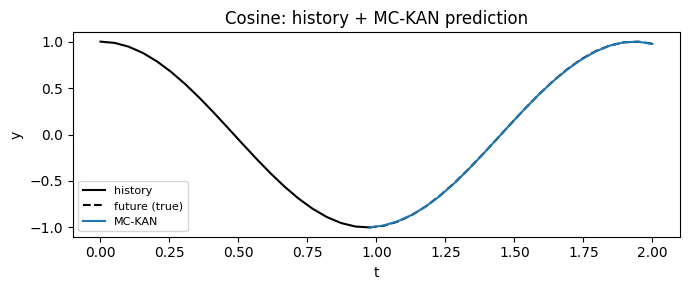

In [84]:
# Pick a sample and plot prediction
idx = 0
t_future = ts[idx]
y_future_true = ys_list[idx]
y_hist = Zs[idx].reshape(-1)
traj = df[df['trajectory_id'] == idx].sort_values('t')
t_hist = traj[traj['t'] <= history_end]['t'].to_numpy()
t_plot = np.concatenate([t_hist[-1:], t_future])
y_true_plot = np.concatenate([y_hist[-1:], y_future_true])

Xb, Zb, Phi, yb = kan_dataset[idx]
with torch.no_grad():
    y_kan = kan_lit.model(Xb.unsqueeze(0), Zb.unsqueeze(0), [Phi])[0].cpu().numpy()

plt.figure(figsize=(7, 3))
plt.plot(t_hist, y_hist, 'k-', label='history')
plt.plot(t_plot, y_true_plot, 'k--', label='future (true)')
plt.plot(t_plot, np.concatenate([y_hist[-1:], y_kan]), label='MC-KAN')
plt.xlabel('t')
plt.ylabel('y')
plt.title('Cosine: history + MC-KAN prediction')
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


## Level-1 transparency: global trajectory trends and properties

We visualize how the model behaves across diverse trajectories (global trends) and how
a trajectory property (period) varies with the static feature $x$.


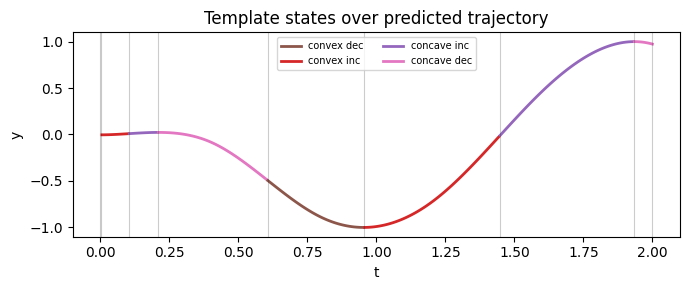

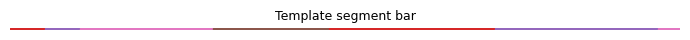

In [88]:
# Template states and transition points for a single trajectory
bspline = BSplineBasis(kan_n_basis, (0, T), internal_knots=kan_cfg.internal_knots)
x_static = X_static[idx:idx+1]
z_dynamic = Zs[idx].reshape(1, -1)
with torch.no_grad():
    h = kan_lit.model.predict_latent_variables(x_static, z_dynamic)[0]

template_states, transition_points = bspline.get_template_from_coeffs(h)
state_colors = {
    0: 'C0',  # line_increasing
    1: 'C1',  # line_decreasing
    2: 'C2',  # line_constant
    3: 'C3',  # convex_increasing
    4: 'C4',  # concave_increasing
    5: 'C5',  # convex_decreasing
    6: 'C6',  # concave_decreasing
}
state_names = {
    0: 'line inc',
    1: 'line dec',
    2: 'line const',
    3: 'convex inc',
    4: 'concave inc',
    5: 'convex dec',
    6: 'concave dec',
}

t_full = np.linspace(0.0, T, 400)
y_full = kan_lit.model.forecast_trajectory(x_static[0], z_dynamic.flatten(), t_full)

plt.figure(figsize=(7, 3))
for s, t0, t1 in zip(template_states, transition_points[:-1], transition_points[1:]):
    mask = (t_full >= t0) & (t_full <= t1)
    plt.plot(t_full[mask], y_full[mask], color=state_colors.get(s, 'k'), linewidth=2)
    plt.axvline(t0, color='k', alpha=0.2, linewidth=0.8)
plt.axvline(transition_points[-1], color='k', alpha=0.2, linewidth=0.8)
plt.title('Template states over predicted trajectory')
plt.xlabel('t')
plt.ylabel('y')
handles = []
labels = []
for s in dict.fromkeys(template_states):
    handles.append(plt.Line2D([0], [0], color=state_colors.get(s, 'k'), lw=2))
    labels.append(state_names.get(s, str(s)))
plt.legend(handles, labels, fontsize=7, ncol=2)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 0.5))
for s, t0, t1 in zip(template_states, transition_points[:-1], transition_points[1:]):
    ax.add_patch(plt.Rectangle((t0, 0), t1 - t0, 1, color=state_colors.get(s, 'k')))
ax.set_xlim(0, T)
ax.set_ylim(0, 1)
ax.axis('off')
plt.title('Template segment bar', fontsize=9)
plt.tight_layout()
plt.show()


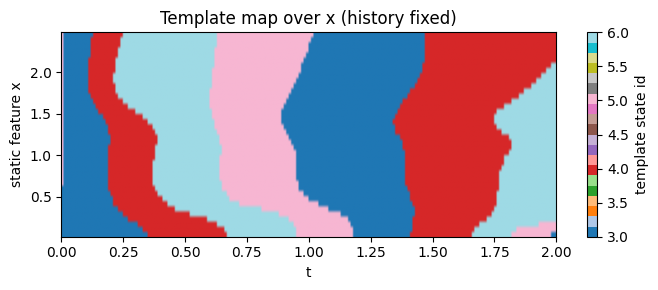

In [89]:
x_grid = np.linspace(float(np.min(X_static[:, 0])), float(np.max(X_static[:, 0])), 40)
t_full = np.linspace(0.0, T, 200)
state_map = np.zeros((len(x_grid), len(t_full)))

for i, x in enumerate(x_grid):
    with torch.no_grad():
        h = kan_lit.model.predict_latent_variables(np.array([[x]]), z_dynamic)[0]
    template_states, transition_points = bspline.get_template_from_coeffs(h)
    for s, t0, t1 in zip(template_states, transition_points[:-1], transition_points[1:]):
        mask = (t_full >= t0) & (t_full <= t1)
        state_map[i, mask] = s

plt.figure(figsize=(7, 3))
plt.imshow(state_map, aspect='auto', origin='lower',
           extent=[0, T, x_grid[0], x_grid[-1]], cmap='tab20')
plt.colorbar(label='template state id')
plt.xlabel('t')
plt.ylabel('static feature x')
plt.title('Template map over x (history fixed)')
plt.tight_layout()
plt.show()


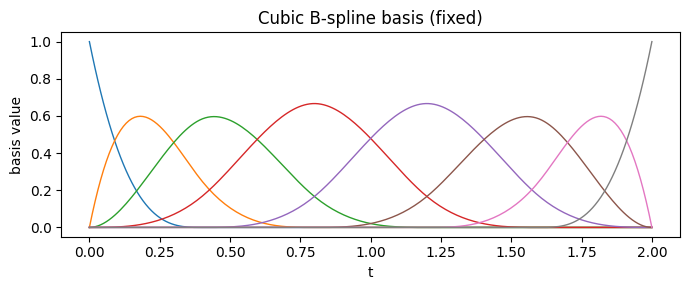

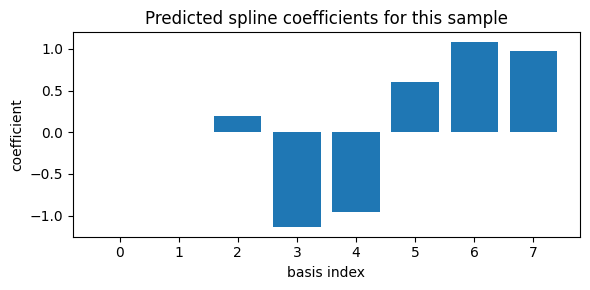

In [90]:
bspline = BSplineBasis(kan_n_basis, (0, T), internal_knots=kan_cfg.internal_knots)
t_vis = np.linspace(0.0, T, 200)
Phi_vis = bspline.get_matrix(t_vis)

x_static = X_static[idx:idx+1]
z_dynamic = Zs[idx].reshape(1, -1)
h = kan_lit.model.predict_latent_variables(x_static, z_dynamic)[0]

plt.figure(figsize=(7, 3))
for i in range(kan_n_basis):
    plt.plot(t_vis, Phi_vis[:, i], linewidth=1)
plt.title('Cubic B-spline basis (fixed)')
plt.xlabel('t')
plt.ylabel('basis value')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.bar(np.arange(kan_n_basis), h)
plt.xlabel('basis index')
plt.ylabel('coefficient')
plt.title('Predicted spline coefficients for this sample')
plt.tight_layout()
plt.show()


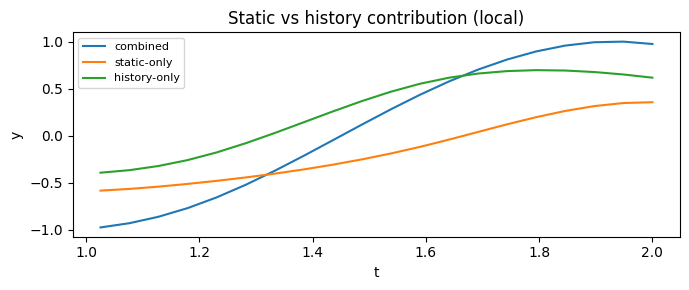

In [93]:
def coeffs_to_traj(coeffs, t_vals):
    Phi = bspline.get_matrix(t_vals)
    return Phi @ coeffs

with torch.no_grad():
    x_t = torch.from_numpy(X_static[idx:idx+1]).float()
    z_t = torch.from_numpy(Zs[idx].reshape(1, -1)).float()
    h_static = kan_lit.model.static_encoder(x_t).detach().cpu().numpy()[0]
    h_dyn = kan_lit.model.dynamic_encoder(z_t).detach().cpu().numpy()[0]

y_static = coeffs_to_traj(h_static, t_future)
y_hist = coeffs_to_traj(h_dyn, t_future)
y_combined = y_static + y_hist

plt.figure(figsize=(7, 3))
plt.plot(t_future, y_combined, label='combined')
plt.plot(t_future, y_static, label='static-only')
plt.plot(t_future, y_hist, label='history-only')
plt.title('Static vs history contribution (local)')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


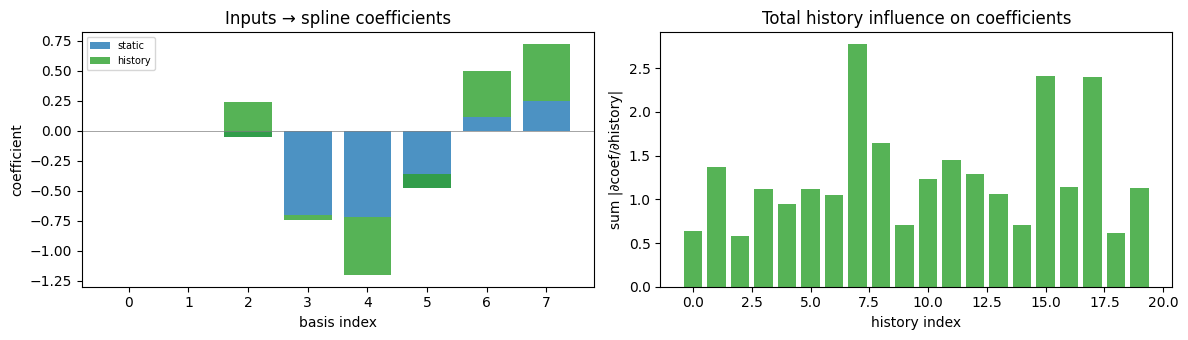

Saved: coef_and_history_influence.png


In [132]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))

ax = axes[0]
if torch.is_tensor(h_static_core):
    h_static_np = h_static_core.detach().cpu().numpy().astype(float).ravel()
else:
    h_static_np = np.array(h_static_core, dtype=float).ravel()

if h_dyn_core is None:
    h_dyn_np = None
elif torch.is_tensor(h_dyn_core):
    h_dyn_np = h_dyn_core.detach().cpu().numpy().astype(float).ravel()
else:
    h_dyn_np = np.array(h_dyn_core, dtype=float).ravel()

idxs = np.arange(len(h_static_np))
ax.bar(idxs, h_static_np, label='static', color='C0', alpha=0.8)
if h_dyn_np is not None:
    ax.bar(idxs, h_dyn_np, bottom=h_static_np, label='history', color='C2', alpha=0.8)
ax.axhline(0, color='gray', linewidth=0.5)
ax.set_title('Inputs → spline coefficients')
ax.set_xlabel('basis index')
ax.set_ylabel('coefficient')
ax.legend(fontsize=7)

ax = axes[1]
ax.bar(np.arange(len(hist_sum)), hist_sum, color='C2', alpha=0.8)
ax.set_title('Total history influence on coefficients')
ax.set_xlabel('history index')
ax.set_ylabel('sum |∂coef/∂history|')

plt.tight_layout()
fig_path = Path('coef_and_history_influence.png')
fig.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()
print('Saved:', fig_path)


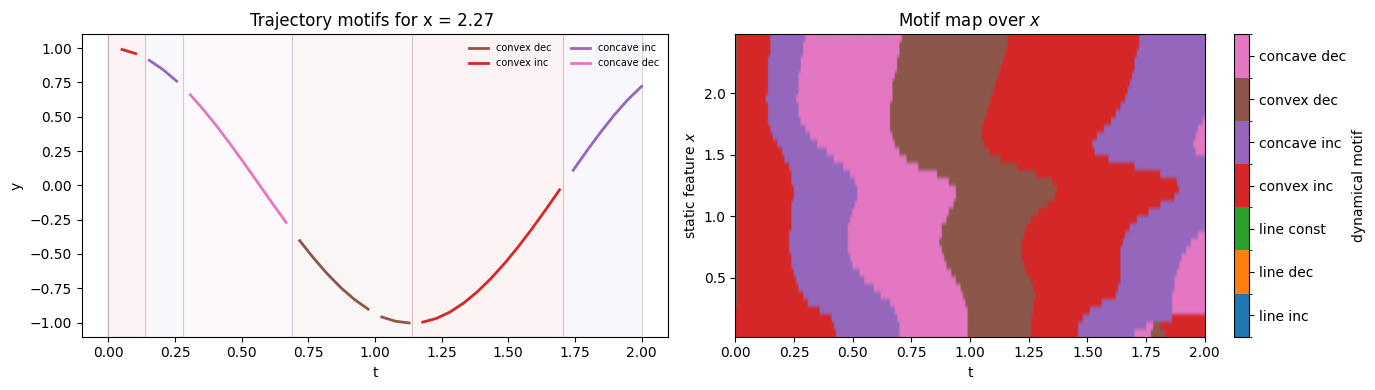

In [101]:

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

ax = axes[0]
for s, t0, t1 in zip(template_states, transition_points[:-1], transition_points[1:]):
    ax.axvspan(t0, t1, color=pastel(state_colors[s]), zorder=0)

    mask_h = (t_hist >= t0) & (t_hist <= t1)
    mask_f = (t_future >= t0) & (t_future <= t1)

    ax.plot(t_hist[mask_h], y_hist[mask_h],
            color=state_colors[s], lw=2)
    ax.plot(t_future[mask_f], y_pred[mask_f],
            color=state_colors[s], lw=2)

    ax.axvline(t0, color='k', alpha=0.15, lw=0.6)

ax.axvline(transition_points[-1], color='k', alpha=0.15, lw=0.6)
ax.set_title('Trajectory motifs for x = 2.27 ')
ax.set_xlabel('t')
ax.set_ylabel('y')

handles = [
    plt.Line2D([0], [0], color=state_colors[s], lw=2)
    for s in dict.fromkeys(template_states)
]
labels = [state_names[s] for s in dict.fromkeys(template_states)]
ax.legend(handles, labels, fontsize=7, ncol=2, frameon=False)


ax = axes[1]
cmap = ListedColormap([state_colors[k] for k in state_names])
norm = BoundaryNorm(np.arange(-0.5, 7.5, 1), cmap.N)

im = ax.imshow(
    state_map, aspect='auto', origin='lower',
    extent=[0, T, x_grid[0], x_grid[-1]],
    cmap=cmap, norm=norm
)

cbar = fig.colorbar(im, ax=ax, ticks=list(state_names))
cbar.ax.set_yticklabels([state_names[k] for k in state_names])
cbar.set_label('dynamical motif')

ax.set_title('Motif map over $x$')
ax.set_xlabel('t')
ax.set_ylabel('static feature $x$')

plt.tight_layout()
plt.savefig("trajectory_and_motif_map.png", dpi=300, bbox_inches="tight")
plt.show()
